In [2]:
import sys
sys.path.append('../')

In [18]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import *

The variational algorithm for the first quantization system requires the Quantum Fourier Transform (QFT) to evaluate the Momentum operator $P$. This fact limits the usage of this approach in current devices since QFT employs many entangling gates. An approach to avoid this problem is the semiclassical implementation of the QFT. This changes the entangling gates with measurements and classical controls, transforming a single entangled circuit into several local circuits with classical communication. In this notebook, we show that obtaining the ground state of the Harmonic oscillator with QFT and semiclassical QFT delivers the same results.

In [4]:
num_qubits = 4
device = qml.device( "default.qubit", 
                    wires=num_qubits)

Creating the Hamiltonian of the harmonic oscilator.

$$H=\frac{1}{2}( P^2 + X^2 ).$$

Notice that here we set the input `semiclassical=True` to work with semmiclassical QFT.

In [6]:
X, P = X_and_P_ops( range(num_qubits), x_min=-5, x_max=5, semiclassical=True ) 

Hamil = [  
        qml.s_prod(0.5,X.pow(2)),
        qml.s_prod(0.5,P.pow(2))
        ]

We can obtain its ground state by matricial calculations.

In [7]:
X_matrix = X.matrix()
P_matrix = P.matrix()
Hamil_matrix = 0.5*np.linalg.matrix_power( X_matrix, 2 ) + 0.5*np.linalg.matrix_power( P_matrix, 2 )
vals, vecs = np.linalg.eigh( Hamil_matrix )
val = vals[0]
vec = vecs[:,0]
val 

0.5000000011276833

Defining the initial state of the circuits and the variational circuit.

In [8]:
def init_state():
    pass 

In [9]:
num_layers = 4
var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_class.construct_circuit

num_params = var_state_class.num_params
num_params

16

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

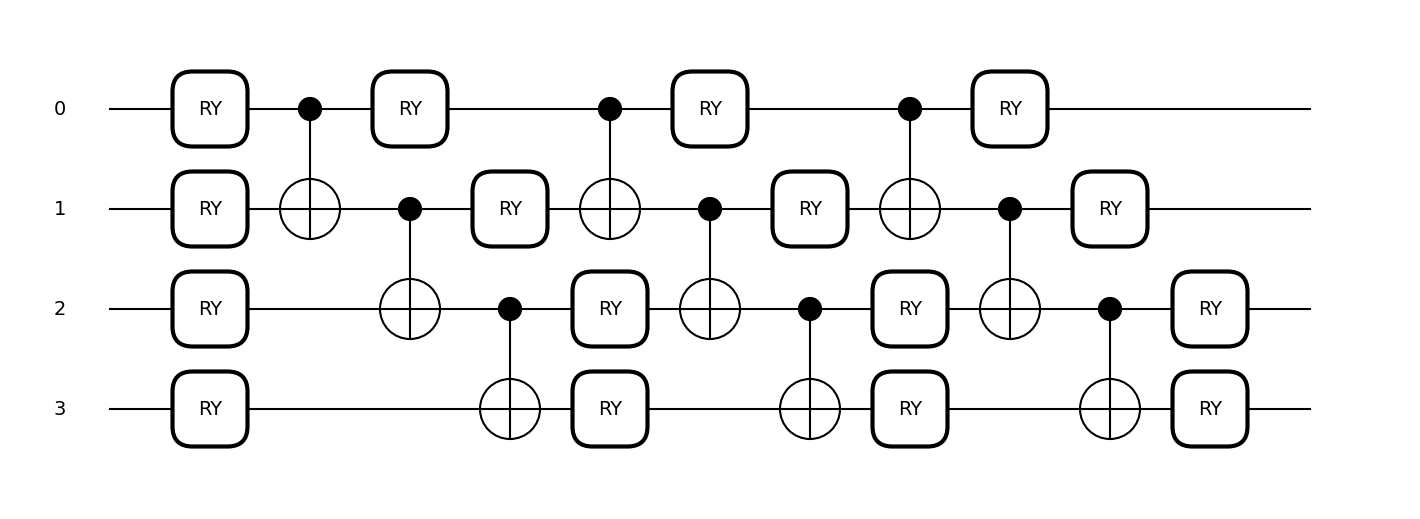

In [10]:
qml.draw_mpl( var_state )( num_params*[0] )

The class ```VarFourier``` create the solver to minimize the energy of the Hamiltonian $H$ over the variational circuit.

In [11]:
varqft = VarFourier( Hamil,
                    device,
                    var_state  = var_state,
                    init_state = init_state
                    )

The optimization is executed by the command ```VarFourier.run```. We have to include the initial condition, the other arguments are optional.

In [12]:
params_init = np.random.randn( num_params )*0.01

params_ground, energies_ground = varqft.run( params_init, max_iterations=500, learning_rate=0.1 )

Step:    136, Energy:     0.501372


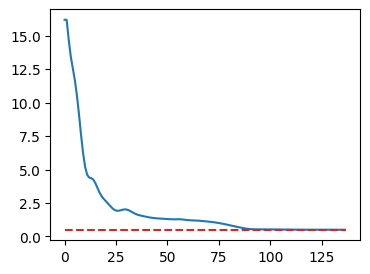

In [13]:
plt.figure( figsize=(4,3) ) 
plt.plot( energies_ground )
plt.hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

Comparing the probability distribution of the estimated ground state $|\tilde{g}\rangle$ and the ideal one $|g\rangle$ we can see that they are very similar. The Fidelity $F=|\langle\tilde{g}|g\rangle|^2$ between them is the following:

In [14]:
ground_state = varqft.state( params_ground[-1] )
abs( np.vdot( ground_state, vec) )**2

0.9995549039257469

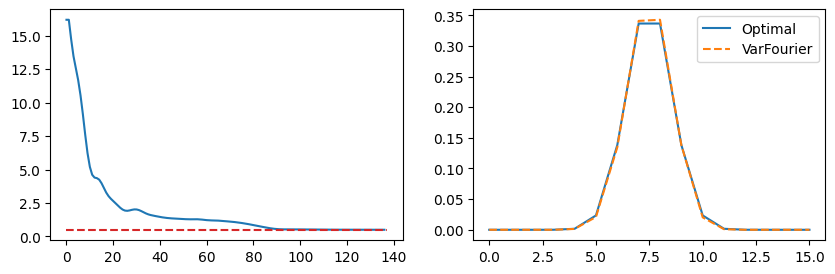

In [15]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' )
ax[1].plot( np.abs(vec)**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

We can see that semiclassical delivers the same results as the standard QFT. However, the semiclassical QFT will have an advantage in a noisy context since it only involves local operations. Moreover, if we mix the semiclassical QFT with circuit cutting techniques, which is very difficult with a standard QFT, the size of the circuits can be reduced even more! The following figure shows an example where the circuit is split into two smaller circuits but with classical communication. Unfortunately, `pennylane` has no classically communicated circuits (and even other quantum software such as `qiskit` neither), so our proposal can not be implemented nowadays.

(<Figure size 1800x625 with 1 Axes>, <Axes: >)

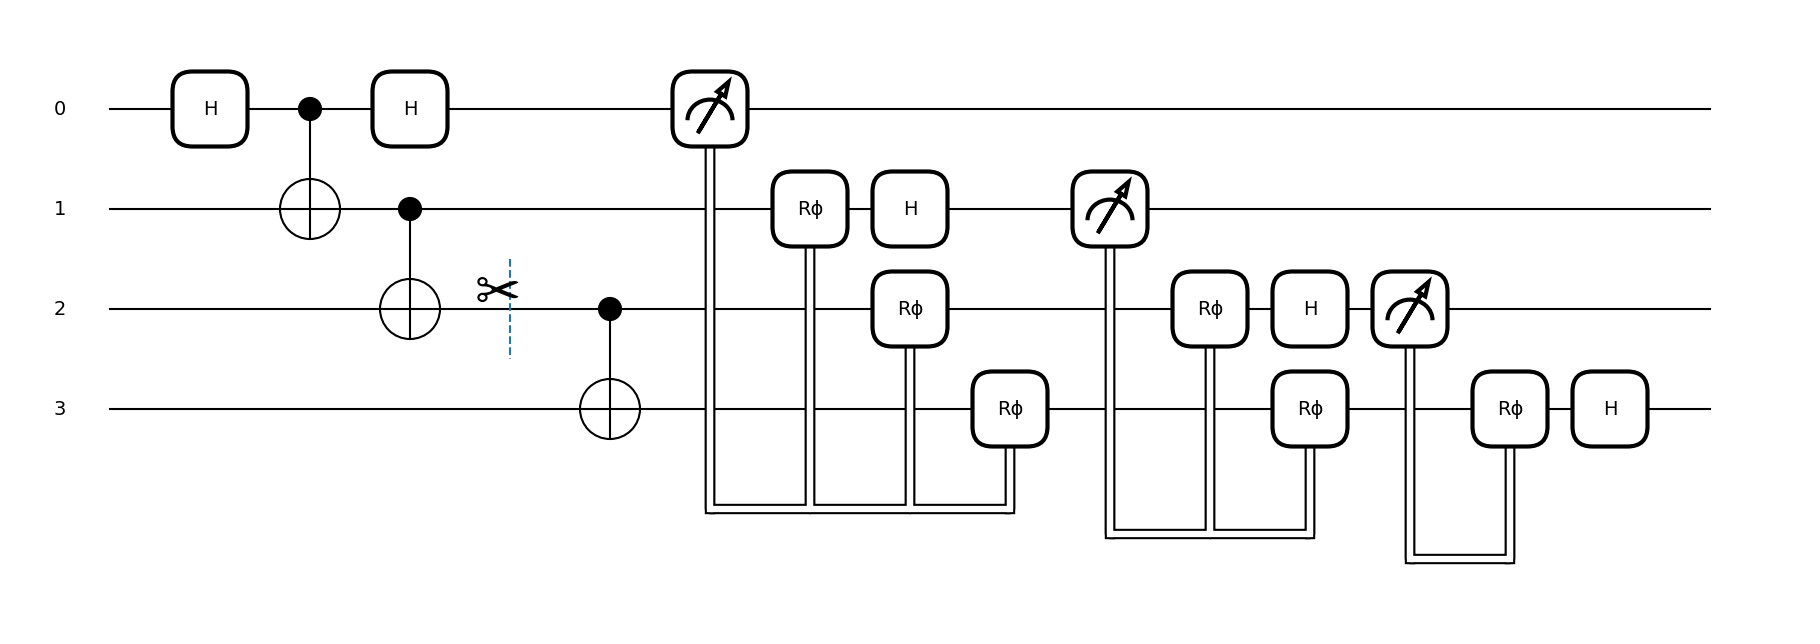

In [26]:
qft = QFT( range(num_qubits), semi_classical=True )
def state_with_QFT_and_cutting():
    qml.Hadamard(0)
    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        if j==1:
            qml.WireCut(wires=j+1)
        
    qft.decomposition() 

qml.draw_mpl( state_with_QFT_and_cutting )()